In [ ]:
# NOTE : this works only in py27, 
# because mechanize does not work 
# in py34 ...
# do  

In [1]:
# Necessary imports ... 

import matplotlib.pyplot as plt
from astropy.table import Table
import os
import numpy as np
from astropy.io import fits
import re
#from mechanize import Browser
import time

In [3]:
#  Read in the DECam - MAF matched data ... 
percent = 0.01 # 0.51  # or 0.06  0.21   0.51
fname = 'table_decam_maf_matched_'+str(percent)+'_density_percent.vo.xml'
decam_maf_table = Table.read(fname)
decam_maf_files = np.array(decam_maf_table['archive_file'].data).astype(str)
print('We read the DECam - MAF matches within 30 arcsec from: \n%s'%fname)

# Check which files are available in the downloads archive dir 
outDir = '../raw_data/DECam/'
print('\nWe have DECam data for %s  percent matched to MAF for : '%str(percent))
mask_available = np.in1d(decam_maf_files, os.listdir(outDir) )
print(decam_maf_files[mask_available])

# choose available fields ....
# since only on those we can run DAOPhot, 
# and it makes sense to get TRILEGAL data 

decam_maf_downloaded = decam_maf_table[mask_available]
decam_maf_downloaded[['ra', 'dec', 'archive_file']]

We read the DECam - MAF matches within 30 arcsec from: 
table_decam_maf_matched_0.01_density_percent.vo.xml

We have DECam data for 0.01  percent matched to MAF for : 
['c4d_140624_081148_ooi_r_v2.fits.fz' 'c4d_140624_080728_ooi_r_v1.fits.fz'
 'c4d_170504_084722_ooi_g_v1.fits.fz' 'c4d_170501_055757_ooi_g_v1.fits.fz'
 'c4d_170428_094150_ooi_g_v1.fits.fz']


ra,dec,archive_file
float64,float64,object
277.98111299999999,-19.083333,c4d_140624_081148_ooi_r_v2.fits.fz
277.943625,-19.120971999999998,c4d_140624_080728_ooi_r_v1.fits.fz
264.04304200000001,-22.608889000000001,c4d_170504_084722_ooi_g_v1.fits.fz
259.22033299999998,-29.295221999999999,c4d_170501_055757_ooi_g_v1.fits.fz
268.43987499999997,-33.630110999999999,c4d_170428_094150_ooi_g_v1.fits.fz


### Run TRILEGAL queries in a loop


Investigated DECam file is c4d_140624_081148_ooi_r_v2.fits.fz
DECam ra,dec = 277.981113, -19.083333
MAF count here is 2590488


In [109]:
def trilegal_counts(fname):
    ''' A convenience function to submit to TRILEGAL
    website the desired field coordinates, 
    filter choice, etc. , to get the TRILEGAL 
    estimate of number counts ...
    '''    
    file_names = np.array(decam_maf_downloaded['archive_file'].data).astype(str)
    mask = file_names == fname
    chosen_field  = decam_maf_downloaded[mask]
    ra = chosen_field['ra'].data.data[0]
    dec = chosen_field['dec'].data.data[0]
    
    hdu = fits.open(outDir+fname)
    print('\nInvestigated DECam file is %s'%fname)
    print('DECam ra,dec = %f, %f'%(ra,dec))
    MAF_count = chosen_field['MAF_px_density'].data.data[0]
    print('MAF count here is %d'%MAF_count)

    x_px_scale = hdu[0].header['PIXSCAL1']  # arcsec / pixel
    y_px_scale = hdu[0].header['PIXSCAL2']
    x_n_pixels = hdu[1].header['NAXIS1']
    y_n_pixels = hdu[1].header['NAXIS2']
    x_arcsec = x_n_pixels * x_px_scale
    y_arcsec = y_n_pixels * y_px_scale
    print('Image size in arcmin is %f by %f'%(x_arcsec / 60, y_arcsec / 60 ))
    area_size_sq_arcsec = x_arcsec * y_arcsec
    area_size_sq_deg = area_size_sq_arcsec / (3600 * 3600)
    print('Single image frame area is %d sq. arcsec, i.e. %f sq.deg.' %(area_size_sq_arcsec, 
                                                        area_size_sq_deg ))
    print('Obtaining TRILEGAL data for object %s '%fname)

    # mechanize : fill in the TRILEGAL form with 
    # an automated python form 
    # this works only with python 2.7 kernel .. 

    print('Querying TRILEGAL for object at given equatorial coordinates')
    print('Within the given area, cutting on r<24.5')
    browser = Browser()
    browser.open("http://stev.oapd.inaf.it/cgi-bin/trilegal")
    browser.select_form(nr=0) # select the first  (and only) available form...
    browser['gal_coord'] = ["2"]  # select galactic coords 
    ra_hrs = (ra/360) * 24.0 # convert degrees to hours 
    browser['eq_alpha'] = str(ra_hrs)  # in hours 
    browser['eq_delta'] = str(dec)  # in degrees 
    browser['field'] = str(area_size_sq_deg)
    photsys_file = "tab_mag_odfnew/tab_mag_lsst.dat"
    browser['photsys_file'] = [photsys_file]
    icm_lim = "3" ; mag_lim = "24.5"
    browser["icm_lim"] = icm_lim
    browser["mag_lim"] = mag_lim                               
    response = browser.submit()
    #content = response.read()
    # print out links to find out 
    # which is the one of interest
    #for link in browser.links():
    #    print link.text, link.url

    print('Asserting that TRILEGAL normally terminated...')
    lastline = ""
    while lastline != '#TRILEGAL normally terminated\n' : 
        # wait for 30 sec...  
        print('Waiting for 30 sec more ...')
        time.sleep(30)
        
        # try downloading the result... 
        url = 'http://stev.oapd.inaf.it/' + str(browser.links()[0].url[3:])
        # note : only read up to -8 position, 
        # so that .fits.fz is not included 
        filename = 'trilegal_' + str(percent) + '_' + fname[:-8] + '.dat'
        browser.retrieve(url, filename)

        # only exit the loop when lastline is 
        # a correct termination
        fi=open(filename, 'r')
        lastline=""
        for line in fi:
            lastline = line

    print('TRILEGAL data saved as %s'%filename)
    # then read the table and count 
    trilegal_data = Table.read(filename, format='ascii')
    f_length = len(trilegal_data)
    n_per_sq_deg = f_length / area_size_sq_deg
    print('There are %d stars in that field , corresponding \
    to %d per square degree '%(f_length,n_per_sq_deg))
    print('\n')
    
    results = {'archive_file':fname , 'ra_deg':ra,'ra_hrs':ra_hrs, 'dec_deg':dec,
              'field':area_size_sq_deg, 'photsys_file':photsys_file,
              'icm_lim':icm_lim, 'mag_lim':mag_lim, 'filename':filename,
              'sources':f_length, 'source_density':n_per_sq_deg, 'MAF_count':MAF_count
              } 
    return results

In [114]:
#run_files = np.array(decam_maf_downloaded['archive_file'].data).astype(str)[4:]

In [141]:
# choose which archive files to run trilegal queries on ....
# we take ra,dec from the DECAM field location 
# this is analogous to chosen list in 
# source_count_DAO.... 
run_files = ['c4d_160607_025052_ooi_g_v1.fits.fz', 'tu2046406.fits.fz',
         'c4d_150615_005257_ooi_g_v1.fits.fz', 'c4d_160825_034122_ooi_g_v1.fits.fz']

In [142]:
#run_files = np.array(decam_maf_downloaded['archive_file'].data).astype(str)[1:]
# run TRILEGAL  queries in the loop, and store results .. 
print('We will run TRILEGAL queries for : ')
print(run_files)

res_dic = {'archive_file':[] , 'ra_deg':[],'ra_hrs':[], 'dec_deg':[],
              'field':[], 'photsys_file':[],
              'icm_lim':[], 'mag_lim':[], 'filename':[],
              'sources':[], 'source_density':[],'MAF_count':[]
          }
           
for j in range(len(run_files)):
    fname = run_files[j]
    results = trilegal_counts(fname)
    for key in results.keys():
        res_dic[key].append(results[key])
        
#Save the results of counting...
fname = 'TRILEGAL_'+str(percent)+'_perc_DECam_MAF_counts.csv'
Table(res_dic).write(fname, overwrite='True')
print('Results of TRILEGAL queries are saved as %s'%fname)

We will run TRILEGAL queries for : 
['c4d_160607_025052_ooi_g_v1.fits.fz', 'tu2046406.fits.fz', 'c4d_150615_005257_ooi_g_v1.fits.fz', 'c4d_160825_034122_ooi_g_v1.fits.fz']

Investigated DECam file is c4d_160607_025052_ooi_g_v1.fits.fz
DECam ra,dec = 233.175667, -1.679167
MAF count here is 20052
Image size in arcmin is 9.207000 by 18.423000
Single image frame area is 610634 sq. arcsec, i.e. 0.047117 sq.deg.
Obtaining TRILEGAL data for object c4d_160607_025052_ooi_g_v1.fits.fz 
Querying TRILEGAL for object at given equatorial coordinates
Within the given area, cutting on r<24.5
Asserting that TRILEGAL normally terminated...
Waiting for 30 sec more ...
Waiting for 30 sec more ...
TRILEGAL data saved as trilegal_0.51_c4d_160607_025052_ooi_g_v1.dat
There are 1395 stars in that field , corresponding     to 29607 per square degree 



Investigated DECam file is tu2046406.fits.fz
DECam ra,dec = 91.807500, -14.163028
MAF count here is 19944
Image size in arcmin is 9.207000 by 18.423000
Single i

In [143]:
# Display the results...
print('percent = %f'%percent)
trilegal = Table.read('TRILEGAL_'+str(percent)+'_perc_DECam_MAF_counts.csv')
trilegal

percent = 0.510000


icm_lim,MAF_count,mag_lim,ra_deg,sources,dec_deg,ra_hrs,source_density,archive_file,filename,field,photsys_file
int64,float64,float64,float64,int64,float64,float64,float64,str34,str44,float64,str31
3,20052.0,24.5,233.175667,1395,-1.679167,15.5450444667,29607.2597001,c4d_160607_025052_ooi_g_v1.fits.fz,trilegal_0.51_c4d_160607_025052_ooi_g_v1.dat,0.0471168225,tab_mag_odfnew/tab_mag_lsst.dat
3,19944.0,24.5,91.8075,1971,-14.163028,6.1205,41832.1927375,tu2046406.fits.fz,trilegal_0.51_tu2046406.dat,0.0471168225,tab_mag_odfnew/tab_mag_lsst.dat
3,21024.0,24.5,223.138875,1302,-11.249944,14.875925,27633.4423867,c4d_150615_005257_ooi_g_v1.fits.fz,trilegal_0.51_c4d_150615_005257_ooi_g_v1.dat,0.0471168225,tab_mag_odfnew/tab_mag_lsst.dat
3,20268.0,24.5,255.384,865266,-39.908583,17.0256,18364268.9402,c4d_160825_034122_ooi_g_v1.fits.fz,trilegal_0.51_c4d_160825_034122_ooi_g_v1.dat,0.0471168225,tab_mag_odfnew/tab_mag_lsst.dat


## Combine DAOStarFinder and TRILEGAL counts

In [105]:
trilegal

icm_lim,MAF_count,mag_lim,ra_deg,sources,dec_deg,ra_hrs,source_density,archive_file,filename,field,photsys_file
int64,float64,float64,float64,int64,float64,float64,float64,str17,str29,float64,str31
3,585576.0,24.5,260.994583,48765,-16.475528,17.3996388667,1034980.65898,tu2093190.fits.fz,trilegal_photsys_file_j-0.dat,0.0471168225,tab_mag_odfnew/tab_mag_lsst.dat
3,641484.0,24.5,260.973083,72055,-18.467306,17.3982055333,1546620.33782,tu1669764.fits.fz,trilegal_photsys_file_j-1.dat,0.04658868,tab_mag_odfnew/tab_mag_lsst.dat
3,599508.0,24.5,259.304375,57513,-19.487611,17.2869583333,1234484.42841,tu1670143.fits.fz,trilegal_photsys_file_j-2.dat,0.04658868,tab_mag_odfnew/tab_mag_lsst.dat
3,795996.0,24.5,262.64325,157874,-19.471278,17.50955,3350692.84437,tu2091292.fits.fz,trilegal_photsys_file_j-3.dat,0.0471168225,tab_mag_odfnew/tab_mag_lsst.dat
3,810144.0,24.5,260.957167,118103,-20.493167,17.3971444667,2535014.94354,tu1677011.fits.fz,trilegal_photsys_file_j-4.dat,0.04658868,tab_mag_odfnew/tab_mag_lsst.dat


In [144]:
from astropy.table import join
percent = 0.51
print('precent = %f'%percent)
trilegal = Table.read('TRILEGAL_'+str(percent)+'_perc_DECam_MAF_counts.csv')
dao = Table.read('DAO_'+str(percent)+'_perc_DECam_MAF_counts.csv')
#dao1 = Table.read('DAO_'+str(percent)+'_perc_DECam_MAF_counts_1.csv')
#from astropy.table import vstack
#dao = vstack([dao0, dao1])
merged= join(trilegal,dao, keys='archive_file',table_names=['TRI', 'DAO'])
merged

precent = 0.510000


icm_lim,MAF_count,mag_lim,ra_deg,sources_TRI,dec_deg,ra_hrs,source_density_TRI,archive_file,filename,field,photsys_file,area_sq_deg,fwhm,threshold,sources_DAO,source_density_DAO
int64,float64,float64,float64,int64,float64,float64,float64,str34,str44,float64,str31,float64,float64,float64,int64,float64
3,21024.0,24.5,223.138875,1302,-11.249944,14.875925,27633.4423867,c4d_150615_005257_ooi_g_v1.fits.fz,trilegal_0.51_c4d_150615_005257_ooi_g_v1.dat,0.0471168225,tab_mag_odfnew/tab_mag_lsst.dat,0.0471168225,5.475378,31.0363521064,608,12904.095984
3,20052.0,24.5,233.175667,1395,-1.679167,15.5450444667,29607.2597001,c4d_160607_025052_ooi_g_v1.fits.fz,trilegal_0.51_c4d_160607_025052_ooi_g_v1.dat,0.0471168225,tab_mag_odfnew/tab_mag_lsst.dat,0.0471168225,6.117483,31.5070427428,630,13371.0205097
3,20268.0,24.5,255.384,865266,-39.908583,17.0256,18364268.9402,c4d_160825_034122_ooi_g_v1.fits.fz,trilegal_0.51_c4d_160825_034122_ooi_g_v1.dat,0.0471168225,tab_mag_odfnew/tab_mag_lsst.dat,0.0471168225,5.76114,41.2491001554,4296,91177.625571
3,19944.0,24.5,91.8075,1971,-14.163028,6.1205,41832.1927375,tu2046406.fits.fz,trilegal_0.51_tu2046406.dat,0.0471168225,tab_mag_odfnew/tab_mag_lsst.dat,0.0471168225,4.202916,55.1179480827,1695,35974.4123238


In [145]:
new_names = [name.replace(r'_', r'\_') for name in merged['archive_file']]
from astropy.table import Column
new_col = Column(new_names, 'archive')
merged['archive'] = new_col

# only here need to add MAF counts 
# nbecause I forgot to add them in TRILEGAL 
# loop  -  later on this should be deleted.
#sampled_objects['archive_file'] = sampled_objects['archive_file'].astype(str)
#merged = join(merged1,  sampled_objects[['archive_file','MAF_px_density']])

#merged.rename_column('archive_file', 'archive')
merged.rename_column('ra_deg','ra')
merged.rename_column('dec_deg','dec')
merged.rename_column('source_density_TRI','TRILEGAL')
merged.rename_column('MAF_count','MAF')
merged.rename_column('source_density_DAO','DAO')

for col in ['TRILEGAL', 'DAO', 'MAF']:
    merged[col] = merged[col].astype(int)
merged[['archive','ra','dec', 'TRILEGAL', 'MAF', 'DAO' ]]

archive,ra,dec,TRILEGAL,MAF,DAO
str39,float64,float64,int64,int64,int64
c4d\_150615\_005257\_ooi\_g\_v1.fits.fz,223.138875,-11.249944,27633,21024,12904
c4d\_160607\_025052\_ooi\_g\_v1.fits.fz,233.175667,-1.679167,29607,20052,13371
c4d\_160825\_034122\_ooi\_g\_v1.fits.fz,255.384,-39.908583,18364268,20268,91177
tu2046406.fits.fz,91.8075,-14.163028,41832,19944,35974


In [146]:
# Convert ra,dec to l,b :
from astropy.coordinates import SkyCoord
coord = SkyCoord(merged['ra'],merged['dec'], frame='icrs', unit='deg')
merged['l'] = coord.galactic.l.deg
merged['b'] = coord.galactic.b.deg

# Save the info : 
# archive_name   |  ra_deg  | dec_deg | MAF count  | DAO count | TRILEGAL count 

# Save as LaTeX file so that I can quickly share with Colin
from astropy.io import ascii
ascii.write(merged[['archive','l','b', 'TRILEGAL', 'MAF', 'DAO' ]], format='latex', 
           formats={'archive': '%.27s', 'l':'%.2f', 'b':'%.2f','TRILEGAL':',d',
                    'MAF':',d', 'DAO':',d'
                   })  
# I could not find a grouping option that would allow 
# to just insert white space rather than a comma... 

\begin{table}
\begin{tabular}{cccccc}
archive & l & b & TRILEGAL & MAF & DAO \\
c4d\_150615\_005257\_ooi\_g & 344.39 & 41.67 & 27,633 & 21,024 & 12,904 \\
c4d\_160607\_025052\_ooi\_g & 2.92 & 41.68 & 29,607 & 20,052 & 13,371 \\
c4d\_160825\_034122\_ooi\_g & 345.83 & 1.28 & 18,364,268 & 20,268 & 91,177 \\
tu2046406.fits.fz & 220.89 & -16.08 & 41,832 & 19,944 & 35,974 \\
\end{tabular}
\end{table}


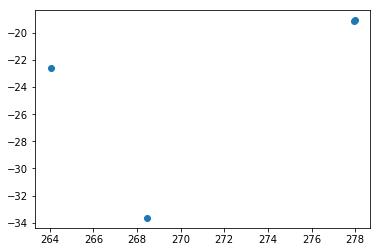

In [49]:
%matplotlib inline
plt.scatter(merged['ra'], merged['dec'])

archive,ra,dec,TRILEGAL,DAO,MAF
str17,float64,float64,float64,float64,float64
tu1669764.fits.fz,260.973083,-18.467306,1545804.68904,376915.594089,641484.0
tu1670143.fits.fz,259.304375,-19.487611,1229290.03354,387454.634903,599508.0
tu1677011.fits.fz,260.957167,-20.493167,2533705.61261,509093.625318,810144.0
tu2091292.fits.fz,262.64325,-19.471278,3357866.50299,434409.599671,795996.0
tu2093190.fits.fz,260.994583,-16.475528,1036105.52261,286712.882644,585576.0


\begin{table}
\begin{tabular}{cccccccccccccccc}
icm_lim & mag_lim & ra_deg & sources_TRI & dec_deg & ra_hrs & source_density_TRI & archive_file & filename & field & photsys_file & area_sq_deg & fwhm & threshold & sources_DAO & source_density_DAO \\
3 & 24.5 & 260.973083 & 72017 & -18.467306 & 17.3982055333 & 1545804.68904 & tu1669764.fits.fz & trilegal_photsys_file_j-1.dat & 0.04658868 & tab_mag_odfnew/tab_mag_lsst.dat & 0.04658868 & 4.877344 & 144.051478584 & 17560 & 376915.594089 \\
3 & 24.5 & 259.304375 & 57271 & -19.487611 & 17.2869583333 & 1229290.03354 & tu1670143.fits.fz & trilegal_photsys_file_j-2.dat & 0.04658868 & tab_mag_odfnew/tab_mag_lsst.dat & 0.04658868 & 4.594288 & 117.533165008 & 18051 & 387454.634903 \\
3 & 24.5 & 260.957167 & 118042 & -20.493167 & 17.3971444667 & 2533705.61261 & tu1677011.fits.fz & trilegal_photsys_file_j-4.dat & 0.04658868 & tab_mag_odfnew/tab_mag_lsst.dat & 0.04658868 & 3.90122 & 130.490627692 & 23718 & 509093.625318 \\
3 & 24.5 & 262.64325 & 15821